In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


load data

In [2]:
sti = "/Users/magnushovmand/Dropbox/UNI/Speciale/Data/ENTSO-E/from_2014/"
df = {}

for region in ["DK_1", "DK_2"]: #tilpas til de regioner man har data for
    try:
        load_and_forecast = pd.read_csv(sti + f"ENTSO-E_load_and_forecast_{region}.csv", parse_dates=[0])
        load_and_forecast.rename(columns={load_and_forecast.columns[0]: 'date'}, inplace=True)
        load_and_forecast['date'] = pd.to_datetime(load_and_forecast['date'], utc=True)
    except: print(f'Failed: "ENTSO-E_load_and_forecast_{region}.csv"')
    try: 
        wind_solar = pd.read_csv(sti + f"ENTSO-E_wind_solar_{region}.csv", parse_dates=[0])
        wind_solar.rename(columns={wind_solar.columns[0]: 'date', 'Solar' : 'p_solar', 'Wind Offshore' : 'p_offshore', 'Wind Onshore' : 'p_onshore'}, inplace=True)
        wind_solar['date'] = pd.to_datetime(wind_solar['date'], utc=True)
    except: print(f'Failed: "ENTSO-E_wind_solar_{region}.csv"')
    try:
        generation_import = pd.read_csv(sti + f"ENTSO-E_generation_import_{region}.csv", parse_dates=[0], skiprows = 1)
        generation_import.rename(columns={generation_import.columns[0]: 'date', 'sum': 'net_export'}, inplace=True)
        columns_to_keep = ['date', 'net_export', 'Biomass', 'Fossil Gas', 'Fossil Hard coal', 'Fossil Oil', 'Hydro Run-of-river and poundage', 'Other renewable', 'Solar', 'Waste', 'Wind Offshore', 'Wind Onshore']
        generation_import = generation_import[generation_import.columns.intersection(columns_to_keep)]
        generation_import['date'] = pd.to_datetime(generation_import['date'], utc=True)
    except: print(f'Failed: "ENTSO-E_generation_import_{region}.csv"')
    try:
        price = pd.read_csv(sti + f"ENTSO-E_price_{region}.csv", parse_dates=[0])
        price.rename(columns={price.columns[0]: 'date', '0' : 'price'}, inplace=True)
        price['date'] = pd.to_datetime(price['date'], utc=True)
    except: print(f'Failed: "ENTSO-E_price_{region}.csv"')
    try:
        for_gen = pd.read_csv(sti + f"ENTSO-E_for_generation_{region}.csv", parse_dates=[0]) #tilføj, når for_gen har kørt
        for_gen.rename(columns={for_gen.columns[0]: 'date', 'Actual Aggregated' : 'Actual generation'}, inplace=True) #find ud af hvad jeg skal gøre med 'Actual generation'
        for_gen['date'] = pd.to_datetime(for_gen['date'], utc=True)
    except: print(f'Failed: "ENTSO-E_for_generation_{region}.csv"')
    try:
        weather = pd.read_csv(sti + f"average_weather_data_{region}.csv", parse_dates=[0])
        weather.rename(columns={weather.columns[0]: 'date', weather.columns[3]: 'temperature'}, inplace=True)
        weather.drop(columns=["parameter_name", "stationId"], inplace = True)
        weather['date'] = pd.to_datetime(weather['date'], utc=True)
    except: print(f'Failed: "ENTSO-E_load_and_forecast_{region}.csv"')
    
    # Merge dataFrames based on 'date'
    merged_df_1 = pd.merge(load_and_forecast, wind_solar, on='date')
    merged_df_2 = pd.merge(generation_import, price, on='date')
    merged_df_2 = pd.merge(merged_df_2, for_gen, on='date')
    merged_df_2 = pd.merge(merged_df_2, weather, on='date')
    df[region] = (pd.merge(merged_df_1, merged_df_2, on='date')
                  .assign(date=lambda x: pd.to_datetime(x['date'], utc=True)))
    df[region]['region'] = region

df = pd.concat([df['DK_1'], df['DK_2']], axis=0)
df['net_export'] = df['Actual generation'] - df['Forecasted Load'] ## ikke nødvendig jf. Janek
df = df.rename(columns={'Wind Offshore':'Offshore', 'Wind Onshore':'Onshore'})
#df[region]['Year', 'Month', 'Day'] = df[region]['date'].dt.year, df[region]['date'].dt.month, df[region]['date'].dt.day
#df[region] = df[region].groupby(['Year', 'Month', 'Day'])

gas = pd.read_excel(sti + "TTF prices.xlsx", sheet_name='Ark2') ## ikke nødvendig jf. Janek
gas = gas.rename(columns={'Date': 'date', 'Mid Price':'gas_price'}) ## ikke nødvendig jf. Janek

#Creating the fourier transformation
df['time_index'] = (df['date'] - df['date'].min()) / pd.Timedelta(hours=1)

def fourier_variable(h, s):
    fourier_cos = np.cos(2*np.pi*h/s)
    fourier_sin = np.sin(2*np.pi*h/s)
    return fourier_cos, fourier_sin

# Apply the function for each s
for s in [168, 8766]: 
    df[f'fourier_h={s}_cos'], df[f'fourier_h={s}_sin'] = zip(*df['time_index'].apply(lambda h: fourier_variable(h, s)))

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['is_weekend'] = ((df['date'].dt.dayofweek == 6) | (df['date'].dt.dayofweek == 5)).astype(int) #creating the weekend dummy

export_path = "/Users/magnushovmand/Dropbox/UNI/Speciale/data/ENTSO-E/from_2014/"
df['date'] = df['date'].dt.tz_localize(None)
df.to_excel(export_path + "df_monthly.xlsx", index=False)

creating variabels

In [12]:
vars = ['Forecasted Load', 'Actual Load', 'p_solar','p_offshore','p_onshore', 'net_export', 'Fossil Gas', 'Solar', 'Offshore', 'Onshore']
df['mean_price'] = df.groupby(['region', df['date'].dt.day, df['date'].dt.month, df['date'].dt.year])['price'].transform('mean')
df['mean_temperature'] = df.groupby(['region', df['date'].dt.day, df['date'].dt.month, df['date'].dt.year])['temperature'].transform('mean')

for var in vars:
            df[f'daily_{var}'] = df.groupby(['region', df['date'].dt.day, df['date'].dt.month, df['date'].dt.year])[var].transform('sum')
            
            if var not in ['Forecasted Load', 'Actual Load']: #
                df[f'earning_{var}'] = df[var] * df['price']
                df[f'daily_revenue_{var}'] = df.groupby(['region', df['date'].dt.day, df['date'].dt.month, df['date'].dt.year])[f'earning_{var}'].transform('sum')
                if var in ['p_solar','p_offshore','p_onshore']:
                    df[f'{var}_penetration'] = df[f'daily_{var}']/df[f'daily_Forecasted Load']*100
                else:
                    df[f'{var}_penetration'] = df[f'daily_{var}']/df[f'daily_Actual Load']*100
                df[f'{var}_UR'] = df[f'daily_revenue_{var}'] / df[f'daily_{var}']
                df[f'{var}_UF'] = df[f'{var}_UR'] / df[f'mean_price']*100
                    
                df.drop([f'earning_{var}', f'daily_revenue_{var}'], axis=1, inplace=True)

creating the daily dfset

In [13]:
# Perform the aggregation
df['date'] = pd.to_datetime(df['date'].dt.date)

df_daily = df.groupby(['region', df['date'].dt.day, df['date'].dt.month, df['date'].dt.year]).agg({
    'date': 'first',
    'p_solar_penetration': 'first',
    'p_offshore_penetration': 'first',
    'p_onshore_penetration': 'first',
    'Solar_penetration': 'first',
    'Offshore_penetration': 'first',
    'Onshore_penetration': 'first',
    'Fossil Gas_penetration': 'first',
    'net_export_penetration': 'first',
    'mean_temperature': 'first',
    'Solar_UR': 'first',
    'Offshore_UR': 'first',
    'Onshore_UR': 'first',
    'Solar_UF': 'first',
    'Offshore_UF': 'first',
    'Onshore_UF': 'first',
    'region': 'first',
    'daily_Forecasted Load': 'first',
    'mean_price': 'first',
    # 'daily_Fossil Gas': 'first',
    # 'daily_p_solar': 'first',
    # 'daily_p_offshore': 'first',
    # 'daily_p_onshore': 'first',
    # 'daily_net_export': 'first'
}).reset_index(drop=True)

df_daily = df_daily[df_daily['date'].dt.year>2014].sort_values('date').reset_index(drop=True)
df_daily.columns = df_daily.columns.str.replace(" ", "_").str.replace("daily_", "").str.replace("Forecasted_", "").str.replace("mean_", "").str.lower() #.str.replace("p_", "")

#Creating the fourier transformation
df_daily['time_index'] = (df_daily['date'] - df_daily['date'].min()) / pd.Timedelta(days=1)

df_daily['is_weekend'] = ((df_daily['date'].dt.dayofweek == 6) | (df_daily['date'].dt.dayofweek == 5)).astype(int) #creating the weekend dummy

In [15]:
# Fourier function
def fourier_variable(h, s):
    fourier_cos = np.cos(2*np.pi*h/s)
    fourier_sin = np.sin(2*np.pi*h/s)
    return fourier_cos, fourier_sin

# Apply the function for each s
for s in [7, 365.25]: 
    df_daily[f'fourier_h={s}_cos'], df_daily[f'fourier_h={s}_sin'] = zip(*df_daily['time_index'].apply(lambda h: fourier_variable(h, s)))

df_daily = pd.merge(df_daily, gas, on='date', how = "left") #indsæt igen, når jeg har fået df for hele ugen uden huller

export

In [16]:
export_path = "/Users/magnushovmand/Dropbox/UNI/Speciale/Data/ENTSO-E/from_2014/"
df_daily.to_excel(export_path + "daily_df.xlsx", index=None)

first difference dataset

# Create a copy of the original DataFrame
df_daily_1diff = df_daily.copy()

# List of variables that won't be differenced
fixed_var_list = ['date', 'region', 'region_dummy', 'time_index', 'fourier_h=7_cos', 'fourier_h=7_sin', 'fourier_h=365_cos', 'fourier_h=365_sin', 'is_monday']

# Loop over each region
for region in ['DK_1', 'DK_2']:
    # Subset DataFrame for specific region
    region_df = df_daily[df_daily['region'] == region].copy()

    # Take the first difference for variables not in fixed_var_list
    for var in df_daily.columns:
        if var not in fixed_var_list:
            region_df[var] = region_df[var].diff()
    
    # Update the corresponding rows in df_daily_1diff
    df_daily_1diff.loc[df_daily['region'] == region, :] = region_df

# Remove the first observation for each group as it will have NA values after differencing
df_daily_1diff = df_daily_1diff.dropna(subset=[var for var in df_daily.columns if var not in fixed_var_list])

df_daily_1diff.to_excel(export_path + "daily_df_1dif.xlsx", index=None)

Plot

df_plot.columns

monthly_average = df_plot[df_plot['year']<2021].groupby('month')['mean_price'].mean()

# Display the result
print(monthly_average)

In [9]:
# Assume df is your DataFrame after loading data
df_plot = df.copy()
df_plot = df_plot[df_plot['region'] == "DK_2"]
område = "_DK2"
df_plot['date'] = pd.to_datetime(df_plot['date'])

# Set 'date' as the index
df_plot.set_index('date', inplace=True)

# Extract year, month, and hour for grouping
df_plot['year'] = df_plot.index.year
df_plot['month'] = df_plot.index.month
df_plot['hour'] = df_plot.index.hour
# Calculate monthly average for solar and wind
monthly_sol = df_plot.groupby(['year', 'month', 'hour'])['Solar'].mean().unstack(level=0)
monthly_landvind = df_plot.groupby(['year', 'month', 'hour'])['Onshore'].mean().unstack(level=0)
monthly_havind = df_plot.groupby(['year', 'month', 'hour'])['Offshore'].mean().unstack(level=0)
#monthly_pris = df_plot.groupby(['year', 'month', 'hour'])['price'].mean().unstack(level=0)
#monthly_consumption = df_plot.groupby(['year', 'month', 'hour'])['price'].mean().unstack(level=0)

months = range(1,13)

# Define line styles and markers
styles = {2015: ('-'),2016: ('-'),2017: ('-'),2018: ('-'),2019: ('-'),2020: ('-'),2021: ('-'),2022: ('-'), 2023: ('-')}

# Define colors
colors = {'Solar': 'orange', 'Landvind': 'brown', 'Havvind': 'blue', 'pris': 'gray', 'forbrug':'orange'}

text_size = 24

def is_odd(n):
    return n % 2 != 0

In [167]:
# Assume df is your DataFrame after loading data
df_plot_temp = df_plot[df_plot['year']<2021].copy()
df_plot_temp = df_plot_temp[df_plot_temp['region'] == "DK_1"]
område = "_DK1"

hourly_stats_pris = df_plot_temp.groupby('hour')['price'].describe(percentiles=[0.1, 0.9])
monthly_stats_pris = df_plot_temp.groupby('month')['price'].describe(percentiles=[0.1, 0.9])

hourly_stats_load = df_plot_temp.groupby('hour')['Actual Load'].describe(percentiles=[0.1, 0.9])
monthly_stats_load = df_plot_temp.groupby('month')['Actual Load'].describe(percentiles=[0.1, 0.9])

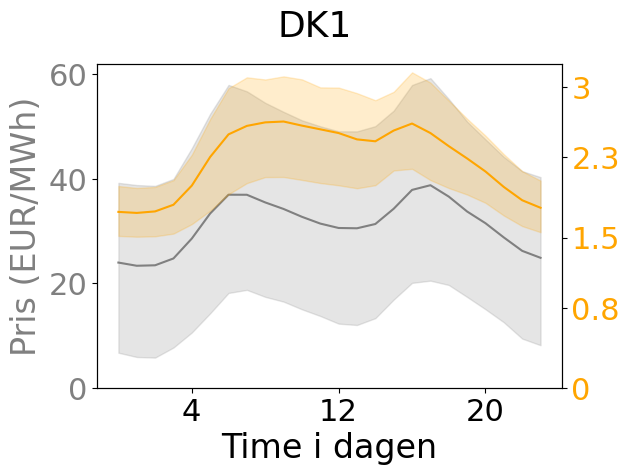

In [168]:
fig, ax = plt.subplots()
fig.suptitle(område[1:], fontsize=text_size+2)
alpha=0.2
ax1 = ax
ax2 = ax1.twinx()

ax1.plot(hourly_stats_pris['mean'], label='Price Mean', color=colors['pris'])
ax1.fill_between(hourly_stats_pris.index, hourly_stats_pris['10%'], hourly_stats_pris['90%'], color=colors['pris'], alpha=alpha)
ax2.plot(hourly_stats_load['mean']/1000, label='Load Mean', color=colors['forbrug'])
ax2.fill_between(hourly_stats_load.index, hourly_stats_load['10%']/1000, hourly_stats_load['90%']/1000, color=colors['forbrug'], alpha=alpha)

ax1.set_xlabel('Time i dagen', fontsize=text_size)
ax1.set_ylabel('Pris (EUR/MWh)', fontsize=text_size, color=colors['pris'])
#ax2.set_ylabel('Forbrug (GWh)', fontsize=text_size, color = colors['forbrug'])

ax2.set_yticks([0, 0.8, 1.5, 2.3, 3])
ax2.set_yticklabels(["0", '0.8', '1.5', '2.3', '3'], color=colors['forbrug'], fontsize = text_size - 2)

ax1.set_yticks([0, 20, 40, 60])
ax1.set_yticklabels(["0", '20', '40', '60'], color=colors['pris'], fontsize = text_size - 2)

ax1.set_xticks([4,12,20])
ax1.tick_params(axis='x', labelsize=text_size - 2)

plt.tight_layout()
fig.savefig(f'forbrug_pris_{område[1:]}_hour.png')
plt.show()

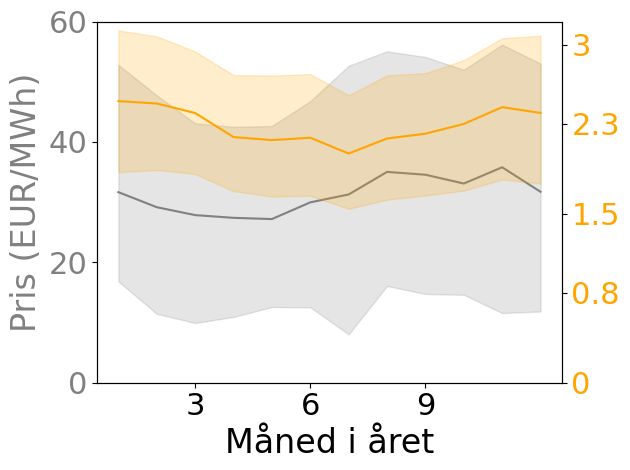

In [169]:
fig, ax = plt.subplots()
#fig.suptitle(område[1:], fontsize=text_size+2)
alpha=0.2
ax1 = ax
ax2 = ax1.twinx()

ax1.plot(monthly_stats_pris['mean'], label='Price Mean', color=colors['pris'])
ax1.fill_between(monthly_stats_pris.index, monthly_stats_pris['10%'], monthly_stats_pris['90%'], color=colors['pris'], alpha=alpha)
ax2.plot(monthly_stats_load['mean']/1000, label='Load Mean', color=colors['forbrug'])
ax2.fill_between(monthly_stats_load.index, monthly_stats_load['10%']/1000, monthly_stats_load['90%']/1000, color=colors['forbrug'], alpha=alpha)

ax1.set_xlabel('Måned i året', fontsize=text_size)
ax1.set_ylabel('Pris (EUR/MWh)', fontsize=text_size, color=colors['pris'])
#ax2.set_ylabel('Forbrug (GWh)', fontsize=text_size, color = colors['forbrug'])

ax2.set_yticks([0, 0.8, 1.5, 2.3, 3])
ax2.set_yticklabels(["0", '0.8', '1.5', '2.3', '3'], color=colors['forbrug'], fontsize = text_size - 2)

ax1.set_yticks([0, 20, 40, 60])
ax1.set_yticklabels(["0", '20', '40', '60'], color=colors['pris'], fontsize = text_size - 2)

ax1.set_xticks([3, 6,9])
ax1.tick_params(axis='x', labelsize=text_size - 2)

plt.tight_layout()
fig.savefig(f'forbrug_pris_{område[1:]}_month.png')
plt.show()

In [170]:
# Assume df is your DataFrame after loading data
df_plot_temp = df_plot[df_plot['year']<2021].copy()
df_plot_temp = df_plot_temp[df_plot_temp['region'] == "DK_2"]
område = "_DK2"

hourly_stats_pris = df_plot_temp.groupby('hour')['price'].describe(percentiles=[0.1, 0.9])
monthly_stats_pris = df_plot_temp.groupby('month')['price'].describe(percentiles=[0.1, 0.9])

hourly_stats_load = df_plot_temp.groupby('hour')['Actual Load'].describe(percentiles=[0.1, 0.9])
monthly_stats_load = df_plot_temp.groupby('month')['Actual Load'].describe(percentiles=[0.1, 0.9])

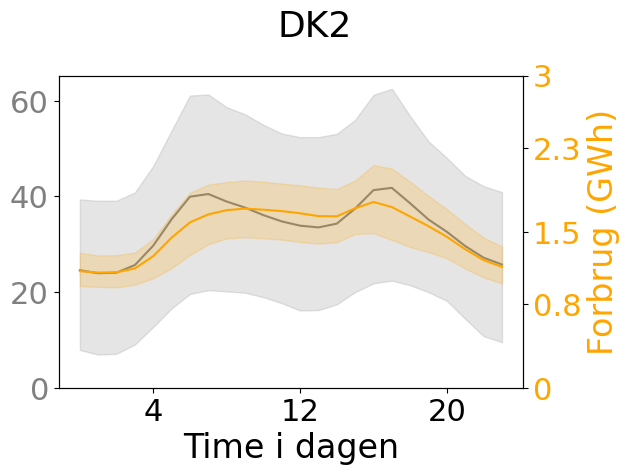

In [171]:
fig, ax = plt.subplots()
fig.suptitle(område[1:], fontsize=text_size+2)
alpha=0.2
ax1 = ax
ax2 = ax1.twinx()

ax1.plot(hourly_stats_pris['mean'], label='Price Mean', color=colors['pris'])
ax1.fill_between(hourly_stats_pris.index, hourly_stats_pris['10%'], hourly_stats_pris['90%'], color=colors['pris'], alpha=alpha)
ax2.plot(hourly_stats_load['mean']/1000, label='Load Mean', color=colors['forbrug'])
ax2.fill_between(hourly_stats_load.index, hourly_stats_load['10%']/1000, hourly_stats_load['90%']/1000, color=colors['forbrug'], alpha=alpha)

ax1.set_xlabel('Time i dagen', fontsize=text_size)
#ax1.set_ylabel('Pris (EUR/MWh)', fontsize=text_size, color=colors['pris'])
ax2.set_ylabel('Forbrug (GWh)', fontsize=text_size, color = colors['forbrug'])

ax2.set_yticks([0, 0.8, 1.5, 2.3, 3])
ax2.set_yticklabels(["0", '0.8', '1.5', '2.3', '3'], color=colors['forbrug'], fontsize = text_size - 2)

ax1.set_yticks([0, 20, 40, 60])
ax1.set_yticklabels(["0", '20', '40', '60'], color=colors['pris'], fontsize = text_size - 2)

ax1.set_xticks([4,12,20])
ax1.tick_params(axis='x', labelsize=text_size - 2)
plt.tight_layout()
fig.savefig(f'forbrug_pris_{område[1:]}_hour.png')
plt.show()

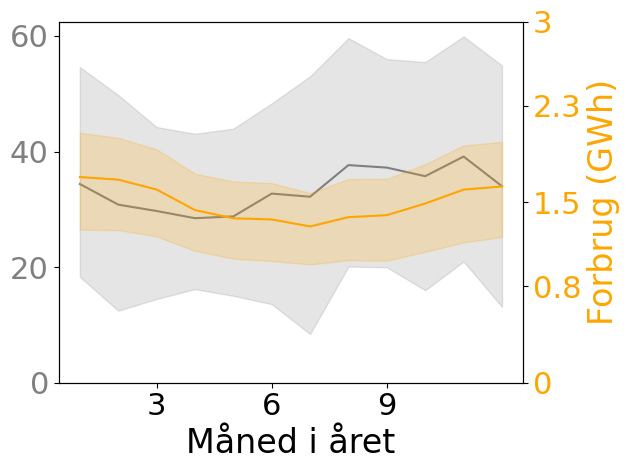

In [172]:
fig, ax = plt.subplots()
#fig.suptitle(område[1:], fontsize=text_size+2)
alpha=0.2
ax1 = ax
ax2 = ax1.twinx()

ax1.plot(monthly_stats_pris['mean'], label='Price Mean', color=colors['pris'])
ax1.fill_between(monthly_stats_pris.index, monthly_stats_pris['10%'], monthly_stats_pris['90%'], color=colors['pris'], alpha=alpha)
ax2.plot(monthly_stats_load['mean']/1000, label='Load Mean', color=colors['forbrug'])
ax2.fill_between(monthly_stats_load.index, monthly_stats_load['10%']/1000, monthly_stats_load['90%']/1000, color=colors['forbrug'], alpha=alpha)

ax1.set_xlabel('Måned i året', fontsize=text_size)
#ax1.set_ylabel('Pris (EUR/MWh)', fontsize=text_size, color=colors['pris'])
ax2.set_ylabel('Forbrug (GWh)', fontsize=text_size, color = colors['forbrug'])

ax2.set_yticks([0, 0.8, 1.5, 2.3, 3])
ax2.set_yticklabels(["0", '0.8', '1.5', '2.3', '3'], color=colors['forbrug'], fontsize = text_size - 2)

ax1.set_yticks([0, 20, 40, 60])
ax1.set_yticklabels(["0", '20', '40', '60'], color=colors['pris'], fontsize = text_size - 2)

ax1.set_xticks([3, 6,9])
ax1.tick_params(axis='x', labelsize=text_size - 2)

plt.tight_layout()
fig.savefig(f'forbrug_pris_{område[1:]}_month.png')
plt.show()

Plot for produktion

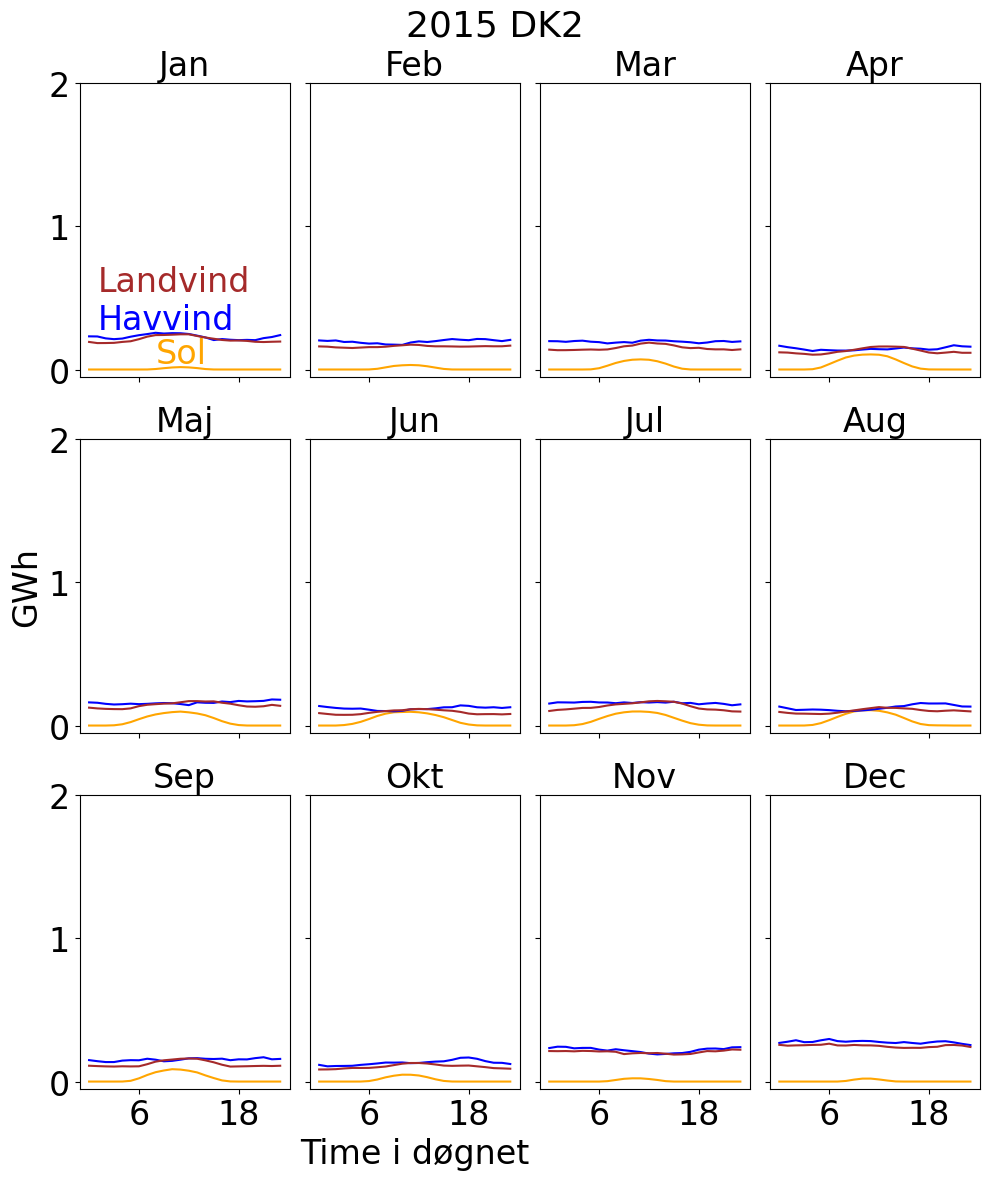

In [10]:
# Create a grid of plots, with 12 subplots for the months
fig, axs = plt.subplots(3, 4, figsize=(10, 12), sharex=True, sharey=True)
fig.suptitle(f'2015 {område[1:]}', fontsize=text_size+2)
axs = axs.flatten()
# axs2 = []

# for ax in axs:
#     ax2 = ax.twinx()
#     axs2.append(ax2)

years = [2015]

# Plot each month
for i, month in enumerate(months):
    ax = axs[i]
    # ax2 = axs2[i]
    for year in years:
        linestyle = styles[year]
        sol, = ax.plot(monthly_sol.loc[(month)].index, monthly_sol.loc[(month), year] /1000,
                color=colors['Solar'], linestyle=linestyle, label=f'Solar {year}')
        havvind, = ax.plot(monthly_havind.loc[(month)].index, monthly_havind.loc[(month), year]/ 1000,
                color=colors['Havvind'], linestyle=linestyle, label=f'Havvind {year}')
        landvind, = ax.plot(monthly_landvind.loc[(month)].index, monthly_landvind.loc[(month), year]/ 1000,
                color=colors['Landvind'], linestyle=linestyle, label=f'Landvind {year}')
        # pris, = ax2.plot(monthly_pris.loc[(month)].index, monthly_pris.loc[(month), year],
        #         color=colors['pris'], linestyle='--', label=f'pris {year}')
    
    ax.set_ybound(lower=-0.05, upper=2)
    # ax2.set_ybound(lower=0, upper=40)

    if i == 4:
        ax.set_title("Maj", size=text_size)

    elif i == 9:
        ax.set_title("Okt", size=text_size)
        
    else:
        ax.set_title(f"{pd.to_datetime(month, format='%m').strftime('%B')[:3]}", size=text_size)

    if i == 0:
        xpos = 6
        ypos = sol.get_ydata()[11]
        ax.text(8, ypos+0.03, 'Sol', color=colors['Solar'], size=text_size)
        ypos = havvind.get_ydata()[11]
        ax.text(1, ypos+0.03, 'Havvind', color=colors['Havvind'], size=text_size)
        ypos = landvind.get_ydata()[11]
        #ax.text(1, ypos+0.03, 'Landvind', color=colors['Landvind'], size=text_size)
        ax.text(1, ypos+0.3, 'Landvind', color=colors['Landvind'], size=text_size) #brug til DK2, da hav og land ligger oven i hinanden
        # ypos = pris.get_ydata()[7]
        # ax2.text(7, ypos, 'Pris', color=colors['pris'], size=text_size)
    
    if i == 4:  # Only add y-axis label for the left column
        ax.set_ylabel('GWh', fontsize=text_size)
    
    # if i == 7:  # Only add y-axis label for the left column
    #     ax2.set_ylabel('Pris (EUR/MWh)', fontsize=text_size)
    
    if i == 9:  # Only add y-axis label for the left column
        ax.set_xlabel('Time i døgnet', fontsize=text_size)

    ax.set_yticks([0, 1, 2])  # Set the positions for the y-ticks
    ax.set_yticklabels(['0', '1', '2'])  # Set the labels for the y-ticks

    # Set the x-ticks only at the desired locations
    ax.set_xticks([6, 18])
    # Set the labels for the specified ticks
    ax.set_xticklabels(['6', '18'])
    # Clear any previously set minor ticks
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.tick_params(axis='both', which='major', labelsize=text_size)

    # if i in [3,7,11]:
    #     ax2.set_yticks([10, 20, 30])  # Set the positions for the y-ticks
    #     ax2.set_yticklabels(['10', '20', '30'])  # Set the labels for the y-ticks
    #     ax2.xaxis.set_minor_locator(plt.NullLocator())
    #     ax2.tick_params(axis='both', which='major', labelsize=text_size)
    # else:
    #     ax2.set_yticks([])

#Adjust layout
plt.tight_layout()
plt.savefig(f'Produktion_2015{område}.png', bbox_inches='tight')
plt.show()

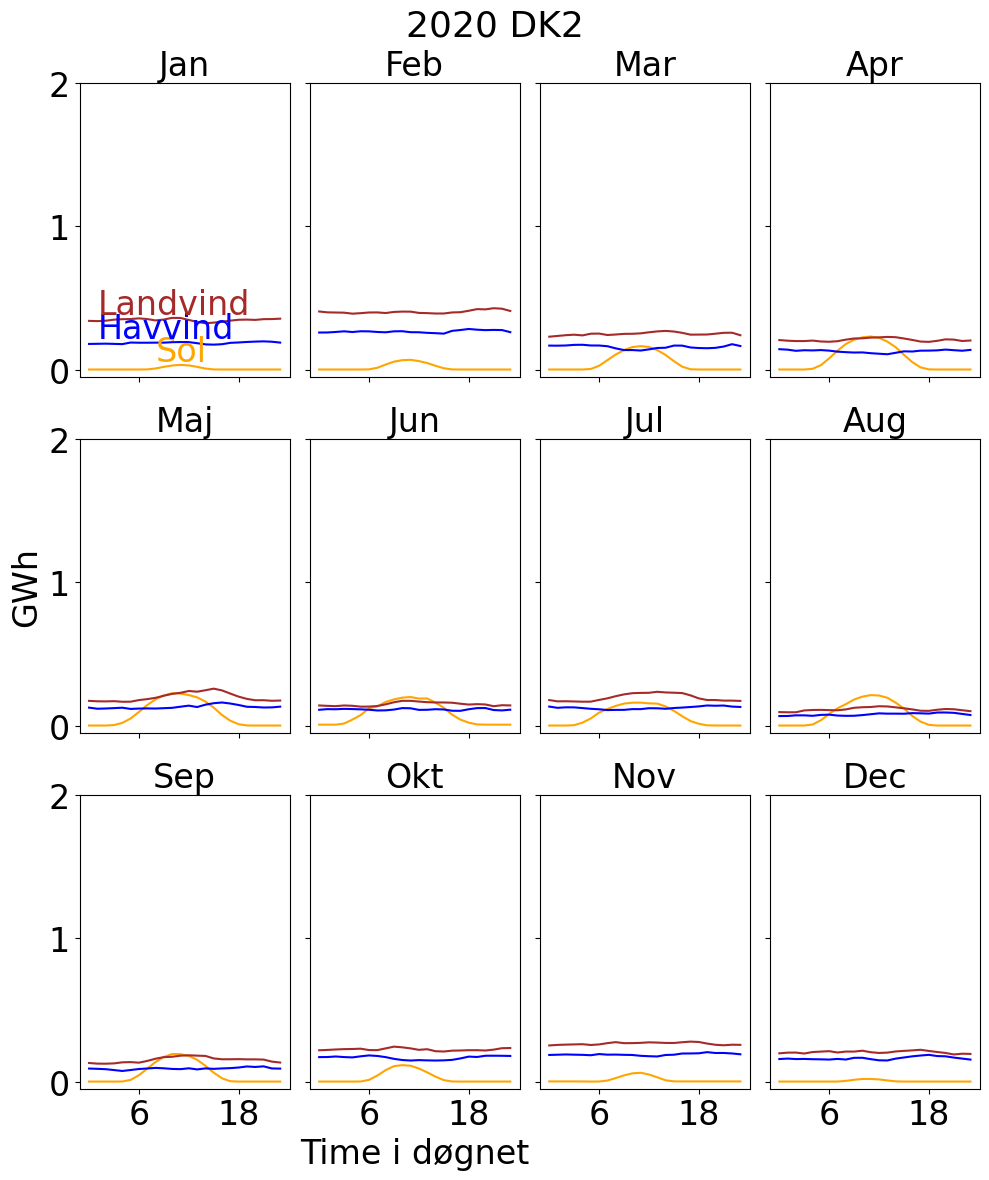

In [11]:
# Create a grid of plots, with 12 subplots for the months
fig, axs = plt.subplots(3, 4, figsize=(10, 12), sharex=True, sharey=True)
fig.suptitle(f'2020 {område[1:]}', fontsize=text_size+2)
axs = axs.flatten()
# axs2 = []

# for ax in axs:
#     ax2 = ax.twinx()
#     axs2.append(ax2)

years = [2020]

# Plot each month
for i, month in enumerate(months):
    ax = axs[i]
    # ax2 = axs2[i]
    for year in years:
        linestyle = styles[year]
        sol, = ax.plot(monthly_sol.loc[(month)].index, monthly_sol.loc[(month), year] /1000,
                color=colors['Solar'], linestyle=linestyle, label=f'Solar {year}')
        havvind, = ax.plot(monthly_havind.loc[(month)].index, monthly_havind.loc[(month), year]/ 1000,
                color=colors['Havvind'], linestyle=linestyle, label=f'Havvind {year}')
        landvind, = ax.plot(monthly_landvind.loc[(month)].index, monthly_landvind.loc[(month), year]/ 1000,
                color=colors['Landvind'], linestyle=linestyle, label=f'Landvind {year}')
        # pris, = ax2.plot(monthly_pris.loc[(month)].index, monthly_pris.loc[(month), year],
        #         color=colors['pris'], linestyle='--', label=f'pris {year}')
    
    ax.set_ybound(lower=-0.05, upper=2)
    # ax2.set_ybound(lower=0, upper=40)

    if i == 4:
        ax.set_title("Maj", size=text_size)

    elif i == 9:
        ax.set_title("Okt", size=text_size)
    else:
        ax.set_title(f"{pd.to_datetime(month, format='%m').strftime('%B')[:3]}", size=text_size)

    if i == 0:
        xpos = 6
        ypos = sol.get_ydata()[11]
        ax.text(8, ypos+0.03, 'Sol', color=colors['Solar'], size=text_size)
        ypos = havvind.get_ydata()[11]
        ax.text(1, ypos+0.03, 'Havvind', color=colors['Havvind'], size=text_size)
        ypos = landvind.get_ydata()[11]
        ax.text(1, ypos+0.03, 'Landvind', color=colors['Landvind'], size=text_size)
        # ypos = pris.get_ydata()[7]
        # ax2.text(7, ypos, 'Pris', color=colors['pris'], size=text_size)
    
    if i == 4:  # Only add y-axis label for the left column
        ax.set_ylabel('GWh', fontsize=text_size)
    
    # if i == 7:  # Only add y-axis label for the left column
    #     ax2.set_ylabel('Pris (EUR/MWh)', fontsize=text_size)
    
    if i == 9:  # Only add y-axis label for the left column
        ax.set_xlabel('Time i døgnet', fontsize=text_size)

    ax.set_yticks([0, 1, 2])  # Set the positions for the y-ticks
    ax.set_yticklabels(['0', '1', '2'])  # Set the labels for the y-ticks

    # Set the x-ticks only at the desired locations
    ax.set_xticks([6, 18])
    # Set the labels for the specified ticks
    ax.set_xticklabels(['6', '18'])
    # Clear any previously set minor ticks
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.tick_params(axis='both', which='major', labelsize=text_size)

    # if i in [3,7,11]:
    #     ax2.set_yticks([10, 20, 30])  # Set the positions for the y-ticks
    #     ax2.set_yticklabels(['10', '20', '30'])  # Set the labels for the y-ticks
    #     ax2.xaxis.set_minor_locator(plt.NullLocator())
    #     ax2.tick_params(axis='both', which='major', labelsize=text_size)
    # else:
    #     ax2.set_yticks([])

#Adjust layout
plt.tight_layout()
plt.savefig(f'Produktion_2020{område}.png', bbox_inches='tight')
plt.show()

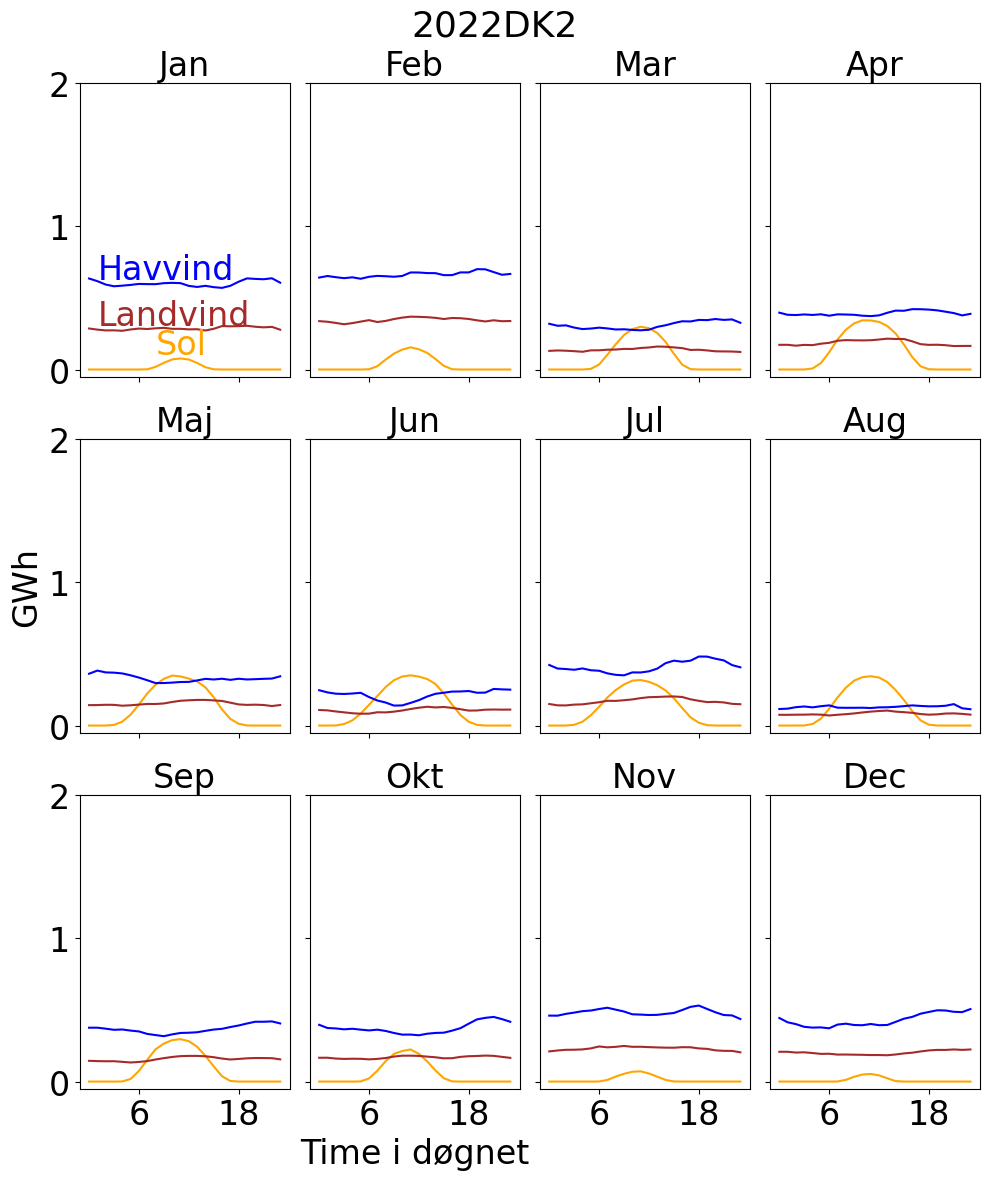

In [12]:
# Create a grid of plots, with 12 subplots for the months
fig, axs = plt.subplots(3, 4, figsize=(10, 12), sharex=True, sharey=True)
fig.suptitle(f'2022{område[1:]}', fontsize=text_size+2)
axs = axs.flatten()
# axs2 = []

# for ax in axs:
#     ax2 = ax.twinx()
#     axs2.append(ax2)

years = [2022]

# Plot each month
for i, month in enumerate(months):
    ax = axs[i]
    # ax2 = axs2[i]
    for year in years:
        linestyle = styles[year]
        sol, = ax.plot(monthly_sol.loc[(month)].index, monthly_sol.loc[(month), year] /1000,
                color=colors['Solar'], linestyle=linestyle, label=f'Solar {year}')
        havvind, = ax.plot(monthly_havind.loc[(month)].index, monthly_havind.loc[(month), year]/ 1000,
                color=colors['Havvind'], linestyle=linestyle, label=f'Havvind {year}')
        landvind, = ax.plot(monthly_landvind.loc[(month)].index, monthly_landvind.loc[(month), year]/ 1000,
                color=colors['Landvind'], linestyle=linestyle, label=f'Landvind {year}')
        # pris, = ax2.plot(monthly_pris.loc[(month)].index, monthly_pris.loc[(month), year],
        #         color=colors['pris'], linestyle='--', label=f'pris {year}')
    
    ax.set_ybound(lower=-0.05, upper=2)
    # ax2.set_ybound(lower=0, upper=40)

    if i == 4:
        ax.set_title("Maj", size=text_size)

    elif i == 9:
        ax.set_title("Okt", size=text_size)
    else:
        ax.set_title(f"{pd.to_datetime(month, format='%m').strftime('%B')[:3]}", size=text_size)

    if i == 0:
        xpos = 6
        ypos = sol.get_ydata()[11]
        ax.text(8, ypos+0.03, 'Sol', color=colors['Solar'], size=text_size)
        ypos = havvind.get_ydata()[11]
        ax.text(1, ypos+0.03, 'Havvind', color=colors['Havvind'], size=text_size)
        ypos = landvind.get_ydata()[11]
        ax.text(1, ypos+0.03, 'Landvind', color=colors['Landvind'], size=text_size)
        # ypos = pris.get_ydata()[7]
        # ax2.text(7, ypos, 'Pris', color=colors['pris'], size=text_size)
    
    if i == 4:  # Only add y-axis label for the left column
        ax.set_ylabel('GWh', fontsize=text_size)
    
    # if i == 7:  # Only add y-axis label for the left column
    #     ax2.set_ylabel('Pris (EUR/MWh)', fontsize=text_size)
    
    if i == 9:  # Only add y-axis label for the left column
        ax.set_xlabel('Time i døgnet', fontsize=text_size)

    ax.set_yticks([0, 1, 2])  # Set the positions for the y-ticks
    ax.set_yticklabels(['0', '1', '2'])  # Set the labels for the y-ticks

    # Set the x-ticks only at the desired locations
    ax.set_xticks([6, 18])
    # Set the labels for the specified ticks
    ax.set_xticklabels(['6', '18'])
    # Clear any previously set minor ticks
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.tick_params(axis='both', which='major', labelsize=text_size)

    # if i in [3,7,11]:
    #     ax2.set_yticks([10, 20, 30])  # Set the positions for the y-ticks
    #     ax2.set_yticklabels(['10', '20', '30'])  # Set the labels for the y-ticks
    #     ax2.xaxis.set_minor_locator(plt.NullLocator())
    #     ax2.tick_params(axis='both', which='major', labelsize=text_size)
    # else:
    #     ax2.set_yticks([])

#Adjust layout
plt.tight_layout()
plt.savefig(f'Produktion_2022{område}.png', bbox_inches='tight')
plt.show()

Plot for price

/var/folders/tj/6_tpq2m10mq0x6dthwtrg8400000gn/T/ipykernel_47431/1578972655.py:44: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(axs[4], labels = years, loc = "center right", bbox_to_anchor=(1, 0.5), ncol = 1, fontsize = text_size) #pris, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(years), fontsize=text_size


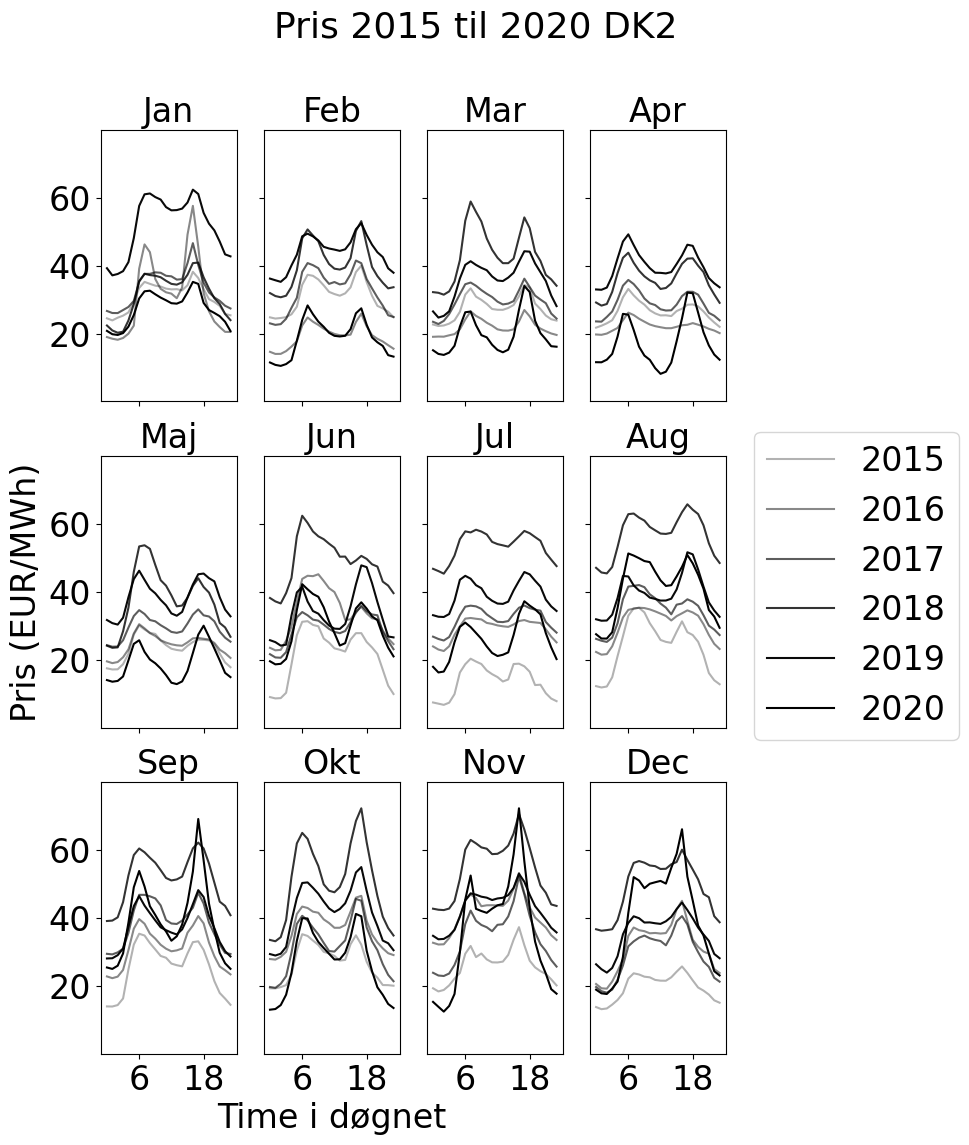

In [64]:
# Create a grid of plots, with 12 subplots for the months
fig, axs = plt.subplots(3, 4, figsize=(10, 12), sharex=True, sharey=True)
fig.suptitle(f'Pris 2015 til 2020 {område[1:]}', fontsize=text_size+2)
axs = axs.flatten()

years = [year for year in range(2015, 2021)]

for i, month in enumerate(months):
    ax = axs[i]
    for year in years:
        linestyle = styles[year]
        alpha = 1 if year == years[-1] else (year - years[0]) / len(years) + 0.3
        pris, = ax.plot(monthly_pris.loc[(month)].index, monthly_pris.loc[(month), year],
                color=colors['pris'], linestyle=linestyle, label=f'pris {year}', alpha=alpha)
        
        ax.set_ybound(lower=0, upper=80)

        if i == 4:
            ax.set_title("Maj", size=text_size)

        elif i == 9:
            ax.set_title("Okt", size=text_size)
        else:
            ax.set_title(f"{pd.to_datetime(month, format='%m').strftime('%B')[:3]}", size=text_size)
        
        if i == 4:  # Only add y-axis label for the left column
            ax.set_ylabel('Pris (EUR/MWh)', fontsize=text_size)
        
        if i == 9:  # Only add y-axis label for the left column
            ax.set_xlabel('Time i døgnet', fontsize=text_size)

        ax.set_yticks([20, 40, 60])  # Set the positions for the y-ticks
        ax.set_yticklabels(['20', '40', '60'])  # Set the labels for the y-ticks

        # Set the x-ticks only at the desired locations
        ax.set_xticks([6, 18])
        # Set the labels for the specified ticks
        ax.set_xticklabels(['6', '18'])
        # Clear any previously set minor ticks
        ax.xaxis.set_minor_locator(plt.NullLocator())
        ax.tick_params(axis='both', which='major', labelsize=text_size)

plt.subplots_adjust(right=0.75)
fig.legend(axs[4], labels = years, loc = "center right", bbox_to_anchor=(1, 0.5), ncol = 1, fontsize = text_size) #pris, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(years), fontsize=text_size
#Adjust layout
#plt.tight_layout()
plt.savefig(f'Pris_2015_2020{område}.png', bbox_inches='tight')
plt.show()

/var/folders/tj/6_tpq2m10mq0x6dthwtrg8400000gn/T/ipykernel_47431/2687802986.py:47: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(axs[4], labels = years, loc = "center right", bbox_to_anchor=(1.22, 0.5), ncol = 1, fontsize = text_size) #pris, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(years), fontsize=text_size


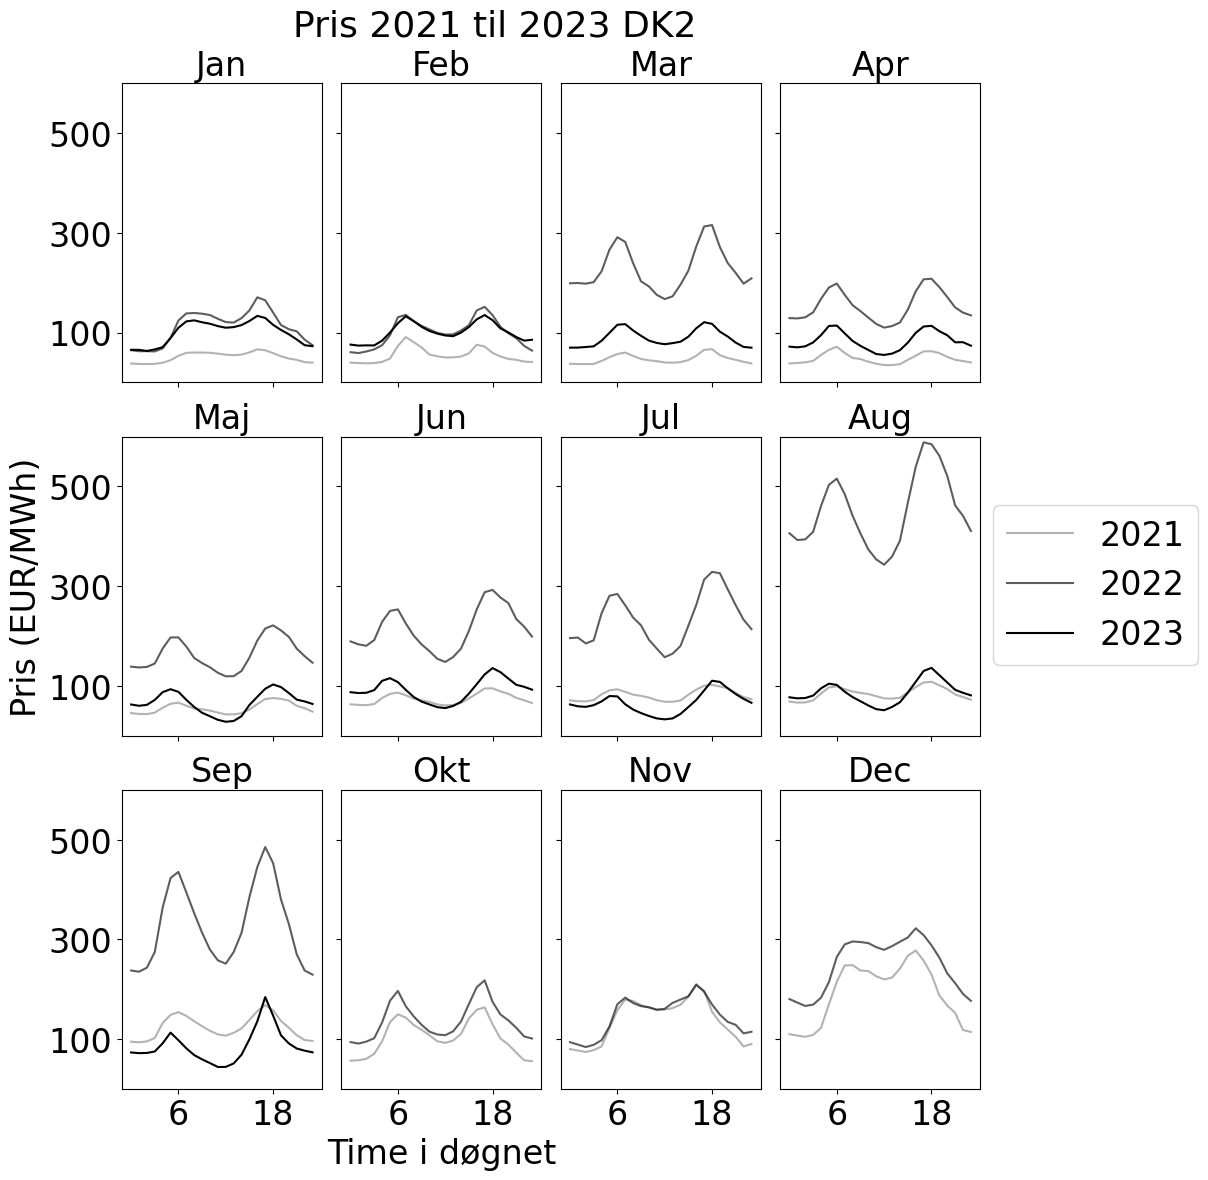

In [65]:


# Create a grid of plots, with 12 subplots for the months
fig, axs = plt.subplots(3, 4, figsize=(10, 12), sharex=True, sharey=True)
fig.suptitle(f'Pris 2021 til 2023 {område[1:]}', fontsize=text_size+2)
axs = axs.flatten()

years = [year for year in range(2021, 2024)]

for i, month in enumerate(months):
    ax = axs[i]
    for year in years:
        linestyle = styles[year]
        alpha = 1 if year == years[-1] else (year - years[0]) / len(years) + 0.3
        try:
            pris, = ax.plot(monthly_pris.loc[(month)].index, monthly_pris.loc[(month), year],
                    color=colors['pris'], linestyle=linestyle, label=f'pris {year}', alpha=alpha)
        except:
            pass
        
        ax.set_ybound(lower=0, upper=600)

        if i == 4:
            ax.set_title("Maj", size=text_size)

        elif i == 9:
            ax.set_title("Okt", size=text_size)
        else:
            ax.set_title(f"{pd.to_datetime(month, format='%m').strftime('%B')[:3]}", size=text_size)
        
        if i == 4:  # Only add y-axis label for the left column
            ax.set_ylabel('Pris (EUR/MWh)', fontsize=text_size)
        
        if i == 9:  # Only add y-axis label for the left column
            ax.set_xlabel('Time i døgnet', fontsize=text_size)

        ax.set_yticks([100, 300, 500])  # Set the positions for the y-ticks
        ax.set_yticklabels(['100', '300', '500'])  # Set the labels for the y-ticks

        # Set the x-ticks only at the desired locations
        ax.set_xticks([6, 18])
        # Set the labels for the specified ticks
        ax.set_xticklabels(['6', '18'])
        # Clear any previously set minor ticks
        ax.xaxis.set_minor_locator(plt.NullLocator())
        ax.tick_params(axis='both', which='major', labelsize=text_size)

#plt.subplots_adjust(right=0.75)
fig.legend(axs[4], labels = years, loc = "center right", bbox_to_anchor=(1.22, 0.5), ncol = 1, fontsize = text_size) #pris, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(years), fontsize=text_size

#Adjust layout
plt.tight_layout()
plt.savefig(f'Pris_2021_2023{område}.png', bbox_inches='tight')
plt.show()

Gennemsnitlig dag - gennemsnitlig år

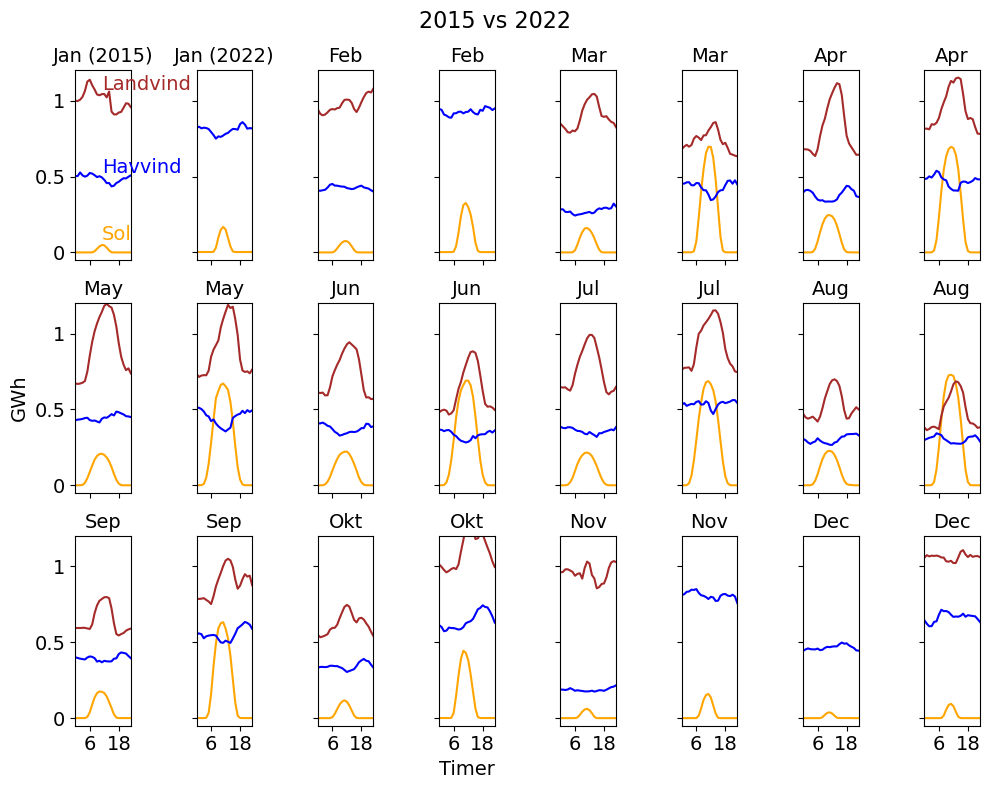

In [39]:
# Create a grid of plots, with 24 subplots for the months (2 years * 12 months)
fig, axs = plt.subplots(3, 8, figsize=(10, 8), sharex=True, sharey=True)  # Adjusted for two columns per month

# Flatten the array for easy iteration
axs = axs.flatten()

# Now, we're considering both years
years = [2015, 2022]

# Plot each month for each year

for i, month in enumerate(months):
    for j, year in enumerate(years):
        idx = i * 2 + j  # Calculate the index for the subplot
        ax = axs[idx]
        
        linestyle = styles[year]
        sol, = ax.plot(monthly_sol.loc[(month)].index, monthly_sol.loc[(month), year] / 1000,  # Divide by 1000 for GWh
                color=colors['Solar'], linestyle=linestyle, label=f'Solar {year}')
        landvind, = ax.plot(monthly_landvind.loc[(month)].index, monthly_landvind.loc[(month), year] / 1000,
                color=colors['Landvind'], linestyle=linestyle, label=f'Landvind {year}')
        havvind, = ax.plot(monthly_havind.loc[(month)].index, monthly_havind.loc[(month), year] / 1000,
                color=colors['Havvind'], linestyle=linestyle, label=f'Havvind {year}')
        
        if month == 1:
            ax.set_title(f"{pd.to_datetime(month, format='%m').strftime('%B')[:3]} ({year})", size=14)
        elif i == 9:
            ax.set_title("Okt", size=14)
        else:
            ax.set_title(f"{pd.to_datetime(month, format='%m').strftime('%B')[:3]}", size=14)

        ax.set_xlim([df_plot.index.hour.min(), df_plot.index.hour.max()])
        ax.xaxis.set_major_locator(mdates.HourLocator(byhour=[6, 18]))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

        ax.set_ybound(lower=-0.05, upper=1.2)

        if idx == 8:  # Only add y-axis label for the left column
            ax.set_ylabel('GWh', fontsize=14)
        
        if idx == 19:  # Only add y-axis label for the left column
            ax.set_xlabel('Timer', fontsize=14)

        if i == 0 and j == 0:
            xpos = 11
            ypos = sol.get_ydata()[11]
            ax.text(xpos, ypos+0.03, 'Sol', color=colors['Solar'], size=14)
            ypos = landvind.get_ydata()[11]
            ax.text(xpos, ypos+0.03, 'Landvind', color=colors['Landvind'], size=14)
            ypos = havvind.get_ydata()[11]
            ax.text(xpos, ypos+0.03, 'Havvind', color=colors['Havvind'], size=14)
            
# Assuming each subplot should have the same y-ticks
y_ticks = [0, 0.5, 1]
y_tick_labels = ['0', '0.5', '1']  # Labels are usually strings
for ax in axs.flat:
    ax.set_yticks(y_ticks)  # Set the positions for the y-ticks
    ax.set_yticklabels(y_tick_labels)  # Set the labels for the y-ticks

for ax in axs.flat:
    # Set the x-ticks only at the desired locations
    ax.set_xticks([6, 18])
    # Set the labels for the specified ticks
    ax.set_xticklabels(['6', '18'])
    # Clear any previously set minor ticks
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.tick_params(axis='both', which='major', labelsize=14)

# Set suptitles for the years
fig.suptitle('2015 vs 2022', fontsize=16)

# Adjust layout
plt.tight_layout()

plt.show()
fig.savefig('Produktion_2015_2022.png', bbox_inches='tight')